# Setup

In [149]:
import numpy as np
from agents_clean import Agent
from model_clean import Model
from hybrid_networks_clean import rewire_network, randomize_network_v2, create_hybrid_network
from tqdm import tqdm
import networkx as nx
import pandas as pd
import random
from simulations_functions_clean import generate_parameters_1, run_simulation_with_params, run_simulations
import numbers
import opinionated
import matplotlib.pyplot as plt
plt.style.use("opinionated_rc")
import colormaps as cmaps  

# Generate Parameters

In [150]:
def generate_parameters_1(n,rewiring_type='hierarchical'):
    params_list = []
    for _ in range(n):
        n_agents = random.randint(10, 500)
        ba_degree = random.randint(1, int(n_agents/10))
        er_prob=random.uniform(0, 0.3)
        p_rewiring = random.uniform(0, 1)
        if rewiring_type=='hierarchical':
            G_er = nx.gnp_random_graph(n_agents, er_prob, directed=True)
            network = rewire_network(G_er, p_rewiring=p_rewiring)
        if rewiring_type=='randomize':
            G_ba = nx.barabasi_albert_graph(n_agents, ba_degree)
            network = randomize_network_v2(G_ba, p_rewiring=p_rewiring)
        # Calculate the mean degree of each node
        degrees = dict(network.degree())
        mean_degree = sum(degrees.values()) / len(degrees)
        uncertainty = random.uniform(0.001,0.01)
        n_experiments = random.randint(1, 1000)
        params = {
            "n_agents": n_agents,
            "ba_degree": ba_degree,
            "er_prob":er_prob,
            "p_rewiring": p_rewiring,
            "network": network,
            "uncertainty": uncertainty,
            "n_experiments": n_experiments,
            "rewiring_type":rewiring_type,
            'mean_degree':mean_degree
        }
        params_list.append(params)
    return params_list

In [151]:
# Example usage
parameter_dictionaries = generate_parameters_1(2,rewiring_type='randomize')  # Generate parameter dictionaries
parameter_dictionaries

[{'n_agents': 94,
  'ba_degree': 2,
  'er_prob': 0.12831812281285923,
  'p_rewiring': 0.47376811869028224,
  'network': <networkx.classes.graph.Graph at 0x7fb4c9779ae0>,
  'uncertainty': 0.0010624165642579124,
  'n_experiments': 181,
  'rewiring_type': 'randomize',
  'mean_degree': 3.8297872340425534},
 {'n_agents': 330,
  'ba_degree': 13,
  'er_prob': 0.1659863274949059,
  'p_rewiring': 0.12587522230988413,
  'network': <networkx.classes.graph.Graph at 0x7fb4c9723e20>,
  'uncertainty': 0.002980227612063184,
  'n_experiments': 686,
  'rewiring_type': 'randomize',
  'mean_degree': 24.757575757575758}]

# Simulation Functions

In [152]:
def run_simulation_with_params(param_dict, number_of_steps=200, agent_type="bayes"):
    # Extract the network directly since it's already a NetworkX graph object
    my_network = param_dict['network']
    #agent_type = param_dict['agent_type']
    # Other parameters are directly extracted from the dictionary
    my_model = Model(my_network, n_experiments=param_dict['n_experiments'], uncertainty=param_dict['uncertainty']
                    , agent_type=agent_type)
    # Run the simulation with predefined steps and show_bar option
    
    my_model.run_simulation(number_of_steps=number_of_steps, show_bar=False)
  
    

    result_dict = {
        key: value 
        for key, value in param_dict.items() 
        if isinstance(value, (numbers.Number, str, tuple, list))}   
    result_dict['true_consensus'] = my_model.conclusion
    result_dict['true_consensus_alternative_stop'] = my_model.conclusion_alternative_stop
    df = pd.DataFrame(my_model.agents_choices) 
    result_dict['choice_consensus'] = df.mean()[len(df.mean())-1]
    result_dict['convergence_step'] = my_model.n_steps # takes note of the last reported step
    result_dict['agent_type']=agent_type
    
    return result_dict


def run_simulations(param_list, number_of_steps=1000,agent_type="bayes"):
    def run_simulation(param_dict):
        return run_simulation_with_params(param_dict, number_of_steps=number_of_steps, agent_type=agent_type)
    
    results = []
    # Iterate over each parameter dictionary in the list
    for params in tqdm(param_list, desc="Running simulations"):
        result = run_simulation(params)
        results.append(result)
    
    # Convert the list of results into a Pandas DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Run Simulations

In [153]:
# Test Simulation
parameter_dictionaries = generate_parameters_1(2,rewiring_type='randomize')  # Generate parameter dictionaries
print(parameter_dictionaries)
test_results_df = run_simulations(parameter_dictionaries, number_of_steps=500, agent_type="bayes")
test_results_df.to_csv('test_results_df.csv', index=False)
test_results_df.head()

[{'n_agents': 208, 'ba_degree': 16, 'er_prob': 0.1867536863974115, 'p_rewiring': 0.08341084527051112, 'network': <networkx.classes.graph.Graph object at 0x7fb4c972c550>, 'uncertainty': 0.008741075868570439, 'n_experiments': 466, 'rewiring_type': 'randomize', 'mean_degree': 29.134615384615383}, {'n_agents': 158, 'ba_degree': 8, 'er_prob': 0.00428265195231341, 'p_rewiring': 0.4859818495591498, 'network': <networkx.classes.graph.Graph object at 0x7fb4c972c190>, 'uncertainty': 0.007811206847838079, 'n_experiments': 334, 'rewiring_type': 'randomize', 'mean_degree': 14.708860759493671}]


Running simulations:   0%|          | 0/2 [00:00<?, ?it/s]

Running simulations: 100%|██████████| 2/2 [00:00<00:00, 23.77it/s]


,n_agents,ba_degree,er_prob,p_rewiring,uncertainty,n_experiments,rewiring_type,mean_degree,true_consensus,true_consensus_alternative_stop,choice_consensus,convergence_step,agent_type
0,208,16,0.186754,0.083411,0.008741,466,randomize,29.134615,1.0,1.0,1.0,8,bayes
1,158,8,0.004283,0.485982,0.007811,334,randomize,14.708861,1.0,1.0,1.0,18,bayes


In [161]:
# Bayes Agent
do_simulation = False
if do_simulation:
    n_sims = 10 # this is for each type of rewiring
    bayes_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['hierarchical','randomize']:
        parameter_dictionaries = generate_parameters_1(n_sims,rewiring_type=rewiring_type)  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=200, agent_type="bayes")
        bayes_results_df = pd.concat([bayes_results_df, results_df1], ignore_index=True)
        
    bayes_results_df.to_csv('bayesagent_results_df.csv', index=False)
bayes_results_df = pd.read_csv('bayesagent_results_df.csv')
bayes_results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   n_agents                         20 non-null     int64  
 1   ba_degree                        20 non-null     int64  
 2   er_prob                          20 non-null     float64
 3   p_rewiring                       20 non-null     float64
 4   uncertainty                      20 non-null     float64
 5   n_experiments                    20 non-null     int64  
 6   rewiring_type                    20 non-null     object 
 7   mean_degree                      20 non-null     float64
 8   true_consensus                   20 non-null     float64
 9   true_consensus_alternative_stop  20 non-null     object 
 10  choice_consensus                 20 non-null     float64
 11  convergence_step                 20 non-null     int64  
 12  agent_type              

In [159]:
# Beta Agent
do_simulation = False
if do_simulation:
    n_sims = 1
    beta_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['hierarchical','randomize']:
        parameter_dictionaries = generate_parameters_1(n_sims,rewiring_type=rewiring_type)  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=100, agent_type="beta")
        beta_results_df = pd.concat([beta_results_df, results_df1], ignore_index=True)
        
    beta_results_df.to_csv('betaagent_results_df.csv', index=False)
beta_results_df = pd.read_csv('betaagent_results_df.csv')
beta_results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   n_agents                         2 non-null      int64  
 1   ba_degree                        2 non-null      int64  
 2   er_prob                          2 non-null      float64
 3   p_rewiring                       2 non-null      float64
 4   uncertainty                      2 non-null      float64
 5   n_experiments                    2 non-null      int64  
 6   rewiring_type                    2 non-null      object 
 7   mean_degree                      2 non-null      float64
 8   true_consensus                   2 non-null      float64
 9   true_consensus_alternative_stop  2 non-null      bool   
 10  choice_consensus                 2 non-null      float64
 11  convergence_step                 2 non-null      int64  
 12  agent_type                

# Now Some Plotting

## Basic Plotting

In [166]:
def plot_results(results_df=results_df,variable_of_interest = 'true_consensus'):
    grouped = results_df.groupby(['rewiring_type', 'n_agents'])[variable_of_interest].mean().reset_index()

    # Preparing for the line plot
    #grouped['mid_bin'] = grouped['binned'].apply(lambda x: x.mid).astype(float)  # Getting the midpoint of bins for plotting

    # Plotting
    plt.figure(figsize=(10, 8))

    for rewiring_type in results_df['rewiring_type'].unique():
        subset = grouped[grouped['rewiring_type'] == rewiring_type]
        plt.plot(subset['n_agents'], subset[variable_of_interest], marker='o', label=rewiring_type)

    plt.xlabel('Number of Agents')
    plt.ylabel('Share of '+variable_of_interest)
    plt.title('Share of '+ variable_of_interest +' by Number of Agents and rewiring_type')
    opinionated.add_legend(title='rewiring_type')

    plt.grid(True)
    plt.show()

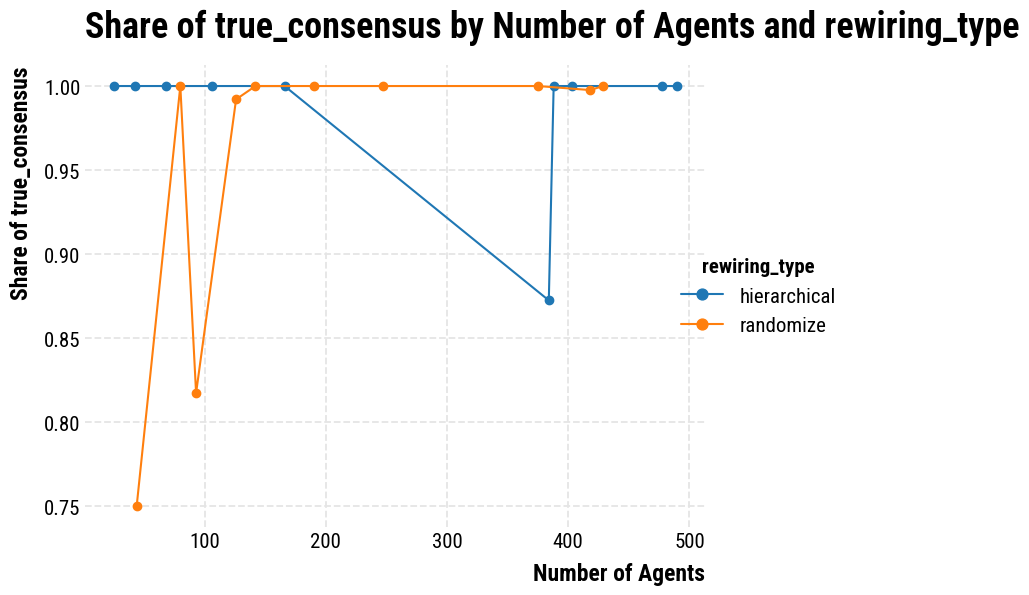

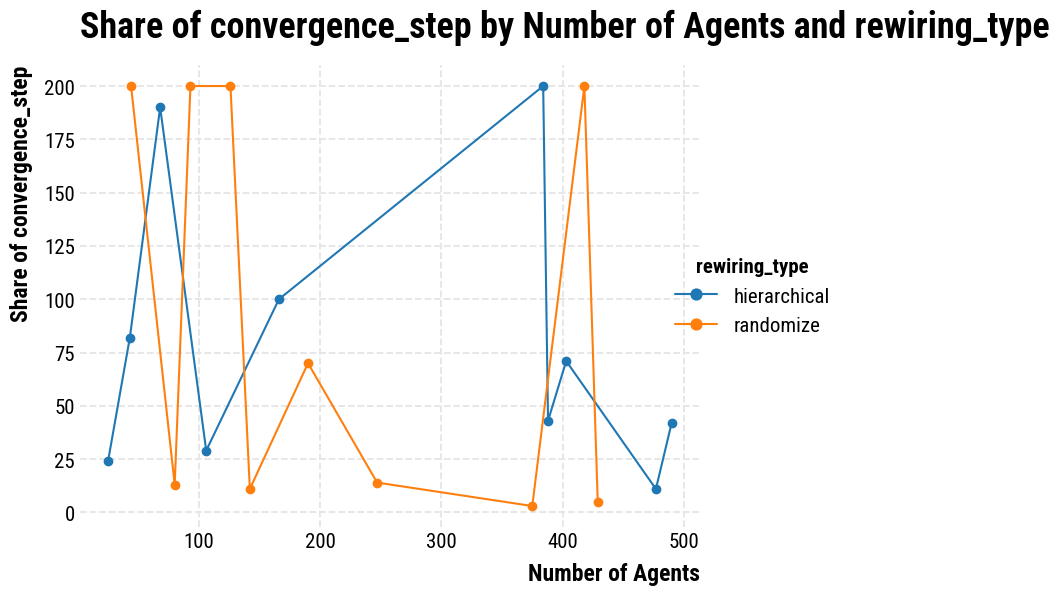

In [167]:
plot_results(bayes_results_df,variable_of_interest = 'true_consensus')
plot_results(bayes_results_df,variable_of_interest = 'convergence_step')

# Advanced Plotting

In [113]:
from pygam import LogisticGAM, s
from sklearn.model_selection import train_test_split


In [133]:
bayes_results_df.head()

,n_agents,ba_degree,er_prob,p_rewiring,uncertainty,n_experiments,rewiring_type,mean_degree,true_consensus,true_consensus_alternative_stop,choice_consensus,convergence_step,agent_type
0,388,27,0.212329,0.285187,0.002063,324,hierarchical,164.046392,1.000000,1.0,1.000000,43,bayes
1,68,1,0.256861,0.784126,0.002188,167,hierarchical,34.117647,1.000000,1.0,1.000000,190,bayes
2,25,2,0.221987,0.649567,0.006193,613,hierarchical,11.280000,1.000000,1.0,1.000000,24,bayes
3,384,37,0.255654,0.127755,0.001883,17,hierarchical,196.406250,0.872396,False,0.859375,200,bayes
4,106,9,0.194228,0.385930,0.005938,329,hierarchical,39.603774,1.000000,1.0,1.000000,29,bayes


In [145]:
def do_regression(results_df=bayes_results_df,variable_of_interest = 'true_consensus'):
    # Splitting the DataFrame by network type
    network_types = results_df['rewiring_type'].unique()

    my_gams = {}

    for network_type in network_types:
        # Subset the DataFrame by network type
        subset = results_df[results_df['rewiring_type'] == network_type]
        
        # Preparing the data
        X = subset[['n_agents','uncertainty','p_rewiring','mean_degree']]
        y = subset[variable_of_interest]#.astype(int)  # Convert boolean to integer
        
        # Splitting the data into training and testing sets for model validation
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Fitting the Logistic GAM model
        gam = LogisticGAM(s(0,n_splines=6)).fit(X_train, y_train)
        
        # Storing the model
        my_gams[network_type] = gam
        
        # Optionally, you can print out model accuracy or other statistics here
        print(f"Model for {network_type}:")
        print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
        print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
        print("-" * 30)
        
    return my_gams,X

do_regression()

Model for hierarchical:
Accuracy on training data: 0.8571428571428571
Accuracy on test data: 1.0
------------------------------
Model for randomize:
Accuracy on training data: 0.7142857142857143
Accuracy on test data: 0.3333333333333333
------------------------------


/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll
/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


({'hierarchical': LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
     fit_intercept=True, max_iter=100, terms=s(0) + intercept, 
     tol=0.0001, verbose=False),
  'randomize': LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
     fit_intercept=True, max_iter=100, terms=s(0) + intercept, 
     tol=0.0001, verbose=False)},
    n_agents  uncertainty  p_rewiring  mean_degree
 10      142     0.007550    0.100761    23.281690
 11      190     0.008980    0.756384    26.442105
 12       44     0.002884    0.916358     1.863636
 13      375     0.009186    0.710161    49.413333
 14       80     0.006021    0.951762    13.600000
 15      418     0.001480    0.643086    53.401914
 16      247     0.004531    0.791867    35.133603
 17      126     0.001993    0.259938    11.142857
 18       93     0.003651    0.443580    15.311828
 19      429     0.008139    0.196564    52.997669)

In [148]:
X.head()

,n_agents,uncertainty,p_rewiring,mean_degree
10,142,0.007550,0.100761,23.281690
11,190,0.008980,0.756384,26.442105
12,44,0.002884,0.916358,1.863636
13,375,0.009186,0.710161,49.413333
14,80,0.006021,0.951762,13.600000


In [146]:
def plot_regression(results_df=bayes_results_df,variable_of_interest = 'true_consensus'):
    my_gams,X = do_regression(results_df=results_df,variable_of_interest = variable_of_interest)
    # Set the size of the figure
    plt.figure(figsize=(10, 6))

    cmap= cmaps.colorblind_10

    X_range = np.linspace(X['n_agents'].min(), X['n_agents'].max(), 100)

    colors =[cmap(0), cmap(1/cmap.N), cmap(1/cmap.N*2)]

    for i, (network_type, gam) in enumerate(my_gams.items()):
        conf = gam.confidence_intervals(X_range.reshape(-1, 1), width=0.95, quantiles=None)
        plt.fill_between(X_range, conf[:, 0], conf[:, 1], facecolor=colors[i], alpha=0.2, interpolate=True)


    for i, (network_type, gam) in enumerate(my_gams.items()):
        # Generating a range of values for n_agents to predict and plot
        # Predicting with the model
        #y_pred, conf = pdep, confi = model.partial_dependence(term=0, width=.95)
        y_pred = gam.predict_proba(X_range.reshape(-1, 1))

        # Plotting predicted probabilities
        plt.plot(X_range, y_pred,c=colors[i], label=f'{network_type}')
        
    # Adding title, labels, and legend
    plt.title('Effect of n_agents on '+ variable_of_interest +' Probability')
    plt.xlabel('Number of Agents')
    plt.ylabel('Probability of ' +variable_of_interest)
    plt.legend()
    plt.show()

In [147]:
plot_regression(bayes_results_df)

Model for hierarchical:
Accuracy on training data: 0.8571428571428571
Accuracy on test data: 1.0
------------------------------
Model for randomize:
Accuracy on training data: 0.7142857142857143
Accuracy on test data: 0.3333333333333333
------------------------------


/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll
/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


ValueError: X data must have 4 features, but found 1

<Figure size 1000x600 with 0 Axes>

In [114]:
plot_full(results_df=bayes_results_df,variable_of_interest = 'true_consensus')
plot_full(results_df=bayes_results_df,variable_of_interest = 'choice_consensus')
plot_full(results_df=bayes_results_df,variable_of_interest = 'convergence_step')

KeyError: "['degree'] not in index"